# Collective search on NK landscapes






This file has an appendix with functions used to develop the current simulation:
* Individual optimization (SHC)
* Features for optimization (gamma & eta seperate)
* Decision making
* Social influence learning (RWL approach + ideas)

## Simulation Schedule Overview

* Problem space: nk Landscape
* Team starts with a random solution state (f.e current portfolio) 


* **1. Individual optimization**
    * Each individual tries to improve the current solution by looking up a neighbouring solution state
    * Represents the thinking process like having ideas or try to engineer something to check a possible change
    * Can result in an improvement, but can also worsen the current state and they were not able to think of something better
    * Result: An idea what could be changed in the current state 


* **2. Information sharing**
    * Everyone has an opinion and information based on their own thinking process (local search)
    * A team is socially connected
    * Information about possible changes are exchanged according to the value
    * Not everyone can discuss their ideas with everyone (Time, Personal preferences, Skills, ...). 
        * Even if every idea would get presented to everyone, some ideas would not be understood, badly communicated, ...
        * Social influence may already be at work here
    * Result: Everyone has different but partially overlapping information about the ideas in the group


* **3. Collective decision making**
    * The team needs to go on and therefore try one of the ideas/ changes to their current state 
    * Different ways to come to a decision:
        * Everyone could vote for one solution based on their knowledge
        * Everyone could vote for one person to make a decision
    * Result: One solution gets implemented, proposed by one agent (but maybe another agent has discovered it)
    
    
* **4. Social influence: value function approximation**
    * To optimize the workflow the team members need to learn who they can trust
    * Having only a few agents who make/ propose good decisions is valuable for the whole team
        * Saves cost in communication/ Enhances performance through better decisions/ Enhances performance by improving communication
    * Agents should grant influence onto their decisions based on their experience
        * Experience: Value (developement) of the solution state; Features of other Individuals
    * Agents need to predict who would help the team
    * *Requirements* for algorithm: 
        * Weights for features; Value of current state; Incremental adjustement; Prediction for different states
    * Result: A social network of granting influence onto behaviour/ information


**Questions**:
* Incorporate uncertainty of information, communication may transfer false or changed information
* Is there a need for a strategic information distribution f.e. based on a network structure, or with distinct rules?


**Ideas**:
* Build in personal satisfaction based on leader attributes: Leaders not only good for better decision, but also for a shared  vision and individual well-being


In [9]:
import numpy as np

# import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import pickle

from scipy.stats.stats import pearsonr

# import seaborn as sns

from ccn_envs import NK_landscape_loaded

rng = np.random.default_rng(0)

In [3]:
# !pip install nb-black # https://black.readthedocs.io/en/stable/index.html
# %load_ext nb_black  

# Use this to not format cell
# fmt: off    
# fmt: on


In [4]:
# file = 'N10K5_50.pkl' # N=10, K=5, 30 landscapes (0-29 )
file = "N20K5_5.pkl"  # "N20K2_5.pkl"

with open(file, "rb") as f:
    landscapes = pickle.load(f)

n_landscapes = int(str(file.split("_")[1]).split(".")[0])
N, K = str(file.split("_")[0])[1:].split("K")
N, K = int(N), int(K)

for i in range(n_landscapes):
    keys = landscapes[i].keys()
    values = np.array(list(landscapes[i].values()))
    values = values ** 6
    landscapes[i] = dict(zip(keys, values))

#### Utils

In [5]:
def softmax(values, b=5, axis=0):
    p = np.exp(values * b) / np.sum(np.exp(values * b), axis).reshape(-1, 1)
    if axis == 0:
        return p[0]
    return np.exp(values * b) / np.sum(np.exp(values * b), axis).reshape(-1, 1)


def bit_switch(digit, state):
    if state[digit] == 1:
        state[digit] = 0
    else:
        state[digit] = 1
    return state

## Leadership Features (Collective Search)

In [281]:
def get_temp(i, max_i, eta):
    # return ((i+1)/max_i) * eta * 20
    return ((-1/(1+i*(eta*0.1)))+1)*20
    # return 20 - 20*np.exp(-eta*0.1*i)

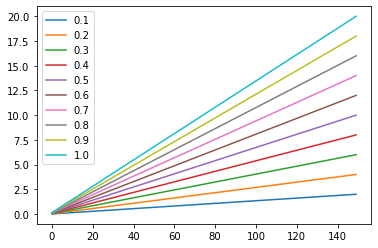

In [232]:
max_i = 150
t = np.arange(max_i)
etas = np.linspace(0.1,1, 10)
temps = [((t+1)/max_i) * eta*20  for eta in etas]
[plt.plot(t, temp, label=round(etas[i], 1)) for i, temp in enumerate(temps)];
plt.legend()

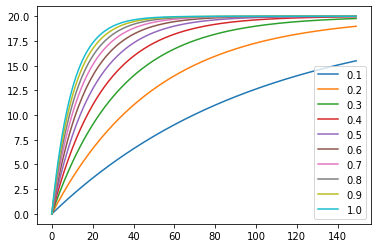

In [280]:
temps = [20 - 20*np.exp(-eta*t) for eta in etas*0.1]
[plt.plot(t, temp, label=round(etas[i], 1)) for i, temp in enumerate(temps)];
plt.legend();

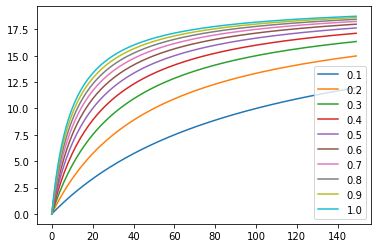

In [275]:
temps = [((-1/(1+t*eta))+1)*20 for eta in etas*0.1]
[plt.plot(t, temp, label=round(etas[i], 1)) for i, temp in enumerate(temps)];
plt.legend();

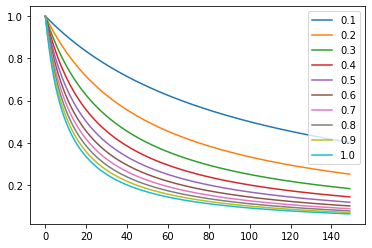

In [279]:
temps = [(1/(1+t*eta)) for eta in etas*0.1]
[plt.plot(t, temp, label=round(etas[i], 1)) for i, temp in enumerate(temps)];
plt.legend();

In [282]:
def run_gamma_eta(env, gamma, eta, iterations, rng):
    """Test if Communication feature makes a difference in performance"""
    # Initialize solution
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_fitness(state)
    
    all_scores = np.empty(iterations+1)
    all_scores[0] = score
    
    for i in range(iterations):
        # Changes of agents
        digits = rng.integers(0, N, n_agents)

        # Evaluation
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        search_scores = np.array([env.get_fitness(search_state) for search_state in search_states])
        
        # Communication
        communication_index = rng.random(n_agents) <= gamma
        communication_index[0] = True
        scores = search_scores[communication_index]
        search_states = search_states[communication_index]
        
        # Same agent draws from its solutions
        p_proposals = softmax(scores, get_temp(i, iterations, eta))
        change_digit = rng.choice(np.arange(len(scores)), p=p_proposals)

        # if scores[change_digit] >= score:
        state = search_states[change_digit]
        score = scores[change_digit]

        all_scores[i+1] = score
    
    return all_scores

In [283]:
rng = np.random.default_rng(1)
iterations = 80
n_trials = 500
n_agents = 7

results = np.empty((n_trials, 3))
print("Start")
for i in range(n_trials):
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0, n_landscapes)])
    
    gamma = rng.random()
    eta = rng.random()
    
    run_scores = run_gamma_eta(env, gamma, eta, iterations, rng)
    results[i] = [gamma, eta, run_scores.mean()]
    
    if i%100 == 0:
        print(i)
print("End")

Start
0
100
200
300
400
End


Corr gamma and mean:  (0.5406046856256805, 2.7397757883798218e-39)
Corr t and mean:  (0.40755497472146446, 1.9765453339950666e-21)
Corr gamma*t and mean:  (0.6844653788398818, 2.3363810034809255e-70)


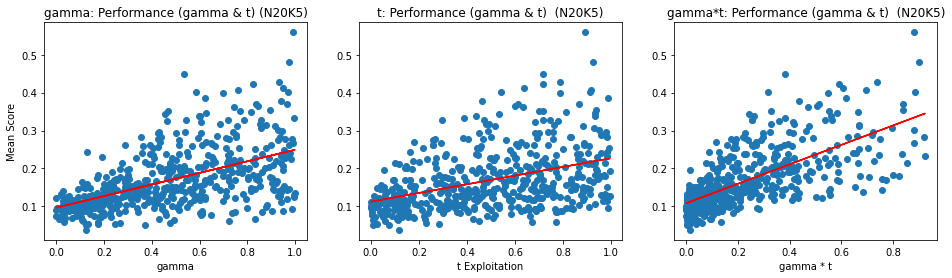

In [284]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))

x = results[:,0]
y = results[:,2]
print("Corr gamma and mean: ", pearsonr(x, y))
axs[0].scatter(x, y)
m, c = np.polyfit(x, y, 1)
axs[0].plot(x, m*x + c, 'r', label='Fitted line')
axs[0].set_xlabel("gamma")
axs[0].set_ylabel("Mean Score")
axs[0].set_title(f"gamma: Performance (gamma & t) (N{N}K{K})")


x = results[:,1]
y = results[:,2]
print("Corr t and mean: ", pearsonr(x, y))
axs[1].scatter(x, y)
m, c = np.polyfit(x, y, 1)
axs[1].set_xlabel("t Exploitation")
axs[1].set_title(f"t: Performance (gamma & t)  (N{N}K{K})")
axs[1].plot(x, m*x + c, 'r')


x = results[:,0] * results[:,1]
y = results[:,2]
print("Corr gamma*t and mean: ", pearsonr(x, y))
axs[2].scatter(x, y)
m, c = np.polyfit(x, y, 1)
axs[2].set_xlabel("gamma * t")
axs[2].set_title(f"gamma*t: Performance (gamma & t)  (N{N}K{K})")
axs[2].plot(x, m*x + c, 'r')

## Minority/ Majority feature
* Draw from two seperate distribution (2 minority & 5 majority agents)
* Mean of distributions should be 0.5 to match the size of the other features
* Regulates access to nk dimensions


**TODO**:
* [ ] Check if std makes a difference for learning weights during regression

[1.5, 1.375, 1.2499999999999998, 1.125, 1.0, 0.875, 0.7499999999999999, 0.6249999999999998, 0.5, 0.37499999999999983, 0.2500000000000001, 0.12499999999999994, -3.885780586188048e-16, -0.12499999999999994, -0.2500000000000003, -0.37499999999999983, -0.5000000000000002]


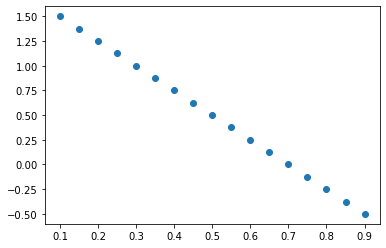

In [26]:
majority = 0.8

def get_minority_mean(majority):
    return (0.5 -(5/7)*majority) * (7/2)

majority_means = np.linspace(0.1,0.9, 17)
plt.scatter(majority_means, [get_minority_mean(m) for m in majority_means])
print([get_minority_mean(m) for m in majority_means])

Good Mean values:  
0.4 & 0.75  Majority/ Minority  
0.6 & 0.25 Majority/ Minority

In [79]:
def create_rho(n=7, majority=0.6, minority=0.25, std=0.1):
    assert n%7 == 0
    rho = np.clip(np.append(
            rng.normal(majority, std, size=(int(n*(5/7)))),
            rng.normal(minority, std, size=(int(n*(2/7))))), 0, 1)
    return rho

def plot_rho_effect(n, scale_rho, majority_mean, minority_mean, std):
    fig, axs = plt.subplots(1,3, figsize=(16,4))
    # rho = np.linspace(0,1, 100)
    n_agents = 700
    rho = create_rho(n_agents, majority_mean, minority_mean, std)

    axs[0].hist(rho)
    axs[0].set_title("Agents rho distribution")
    axs[0].set_xlabel("rho")
    axs[0].set_xlim([0, 1])

    scaled_rho = scale_rho(rho)
    y = np.clip(np.round(scaled_rho), 1,18)
    dimension_values = []
    for X, Y in zip(rho,y):
        dimension_values.extend([Y-1,Y,Y+1])
        axs[1].plot([X,X,X], [Y-1,Y,Y+1], c="b")
    axs[1].set_xlabel("rho")
    axs[1].set_ylabel("Access to Dimension")
    axs[1].set_title(f"Relationship between rho and information access ({n} Agents)")
    axs[1].set_xlim([0, 1])
    axs[1].set_ylim([0, 19])

    axs[2].hist(np.array(dimension_values))
    axs[2].set_xlabel("Dimension")
    axs[2].set_ylabel("# of agents with access")
    axs[2].set_title("Populations information access")
    axs[2].set_xlim([0, 19])
    plt.show()

    
def scale_rho(rho):
    return 1 + rho * 18

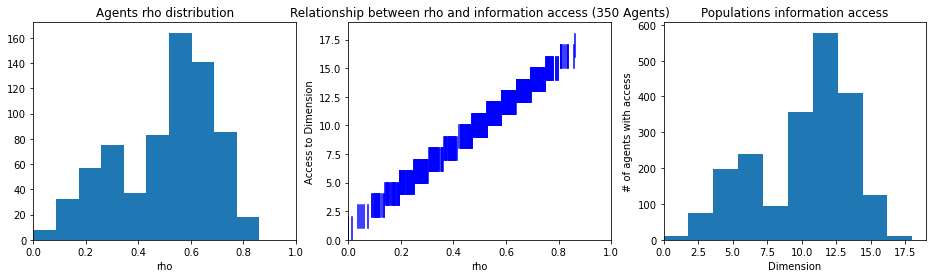

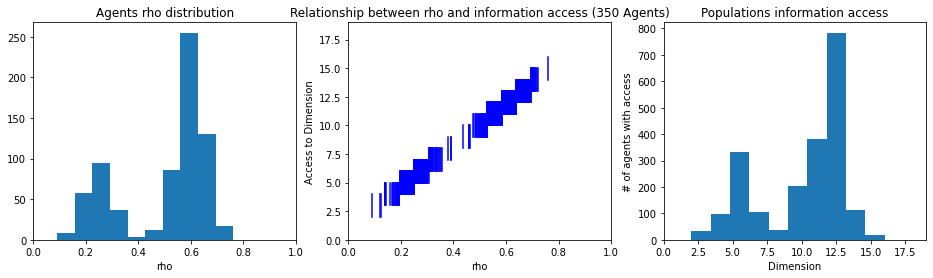

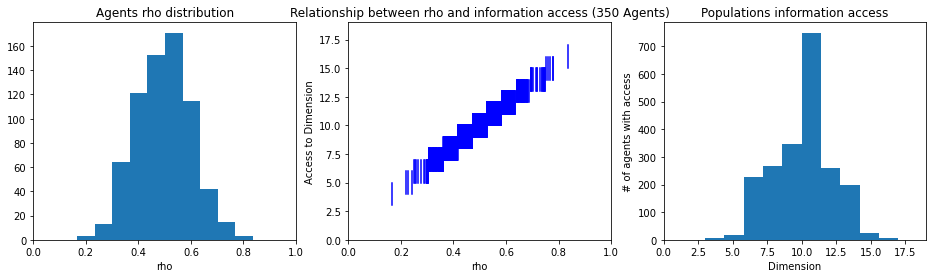

In [80]:
majority_mean = 0.6
minority_mean = .25
std = 0.1
n = 350

plot_rho_effect(n, scale_rho, majority_mean, minority_mean, std)

# std = 0.05
# plot_rho_effect(n, scale_rho, majority_mean, minority_mean, std)

majority_mean = 0.5
minority_mean = .5
std = 0.1
n = 350
plot_rho_effect(n, scale_rho, majority_mean, minority_mean, std)

In [170]:
def create_feature_vector(n_agents, majority=0.6, minority=0.25, std=0.1, rng=None):
    """Feature matrix F (agents x features): F[agent_i] = [gamma, eta, noise, rho]"""
    f = rng.random((n_agents, 3))
    rho = create_rho(n_agents, majority, minority, std)
    f = np.concatenate((f, rho.reshape(-1,1)), axis=1)
    rng.shuffle(f)
    return f


## All Simulation steps 

In [81]:
def init_weights(f, score, n_agents, n_features, rng):
    """sample from gauß with mean for perfect estimation"""
    w = np.ones(n_features) * ((score/n_features) / f.mean())
    return rng.normal(w, 0.1, (n_agents, n_features))


def speaker_gradients(w, f_i, new_score):
    """
    Derivative of Mean Squared Error
    f_i: features of speaker
    w: Weights
    """
    dL = -(new_score - w@f_i).reshape(-1,1) * f_i
    return dL


def get_individual_labels(etas, all_scores, speaker_score, speaker, temp):
    """Label: Normalized Speaker value compared with own choice"""
    values = np.zeros(n_agents)
    for agent_i in range(n_agents):
        agent_scores = all_scores[agent_i]
        p_ideas = softmax(agent_scores, temp * etas[agent_i])
        values[agent_i] = rng.choice(agent_scores, p=p_ideas)
    values[speaker] = speaker_score
    # return values
    
    # get individual labels
    return np.clip(speaker_score - values, 0, 100) # *10
    
    
    # get normalized speaker score
    values -= min(values)

    if values.sum() == 0:
        return 0.5
    return (values / values.max())[speaker]

In [308]:
def run_Regression_voting(env, f, iterations, rng):
    """Test if Communication feature makes a difference in performance"""
    # Initialize solution
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_fitness(state)
    
    gammas = f[:,0]
    etas = f[:,1] # * 20
    rho_scaled = np.clip(np.round(scale_rho(f[:,-1])), 1,18)
    rho_dimensions = np.array([rho_scaled + shift for shift in range(-1,2)]).T  # np broadcast is slower
    
    # w = init_weights(f, score, n_agents, 4, rng)
    w = rng.normal(0, 0.01, (n_agents, 4))
    
    score_tracker = np.empty(iterations+1)
    score_tracker[0] = score
    
    weight_tracker = np.zeros((iterations+1, n_features))
    weight_tracker[0] = w.mean(axis=0)
    
    agents_index = np.arange(n_agents)
    
    leadership_score = np.zeros((n_agents, n_agents))
    
    
    for i in range(iterations):
        state_prediction = np.inner(w, f)
        
        # Changes of agents
        digits = rng.integers(0,19, size=n_agents)
        # digits = rng.choice(rho_dimensions, axis=1).astype(int)
        # digits = np.clip(rng.normal(rho, np.ones(n_agents)*2, size=(n_agents)).round().astype(int), 0,(N-1))
        
        # Evaluation
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_fitness(search_state) for search_state in search_states])
        if i == 0:
            w = np.ones((n_agents, n_features)) * (scores.std()/4)
            weight_tracker[0] = w.mean(axis=0)
        
        # Information sharing/ Communication
        # TODO: Incorporate Leadership matrix into the information sharing process (maybe also cost)
        all_agent_scores = dict()
        all_agent_states = dict()
        for agent_i in range(n_agents):
            communication_index = rng.random(n_agents) <= gammas[agent_i]
            all_agent_scores[agent_i] = scores[communication_index]
            all_agent_states[agent_i] = search_states[communication_index]

        # Vote
        p_votings = softmax(state_prediction, 5, axis=1)
        votes = []
        for p in p_votings:
            votes.append(rng.choice(np.arange(n_agents), p=p))
        
        vote_agent_index, vote_count = np.unique(np.array(votes), return_counts=True)
        speaker = list(vote_count).index(max(vote_count))        # TODO: Always returns first index (if tie always the same gets chosen)
        
        for a_i in range(n_agents):
            if len(all_agent_scores[a_i]) == 0:
                all_agent_scores[a_i] = np.array([scores[a_i]])
                all_agent_states[a_i] = np.array([search_states[a_i]])

        # Speaker draws from its known solutions
        speaker_scores = all_agent_scores[speaker]
        temp = get_temp(i, iterations, etas[speaker])
        p_proposals = softmax(speaker_scores, temp)
        change_digit = rng.choice(np.arange(len(speaker_scores)), p=p_proposals)
        
        # Update belief about features (value function approximation)
        lr = 0.1
        # v = (speaker_scores[change_digit] - score) * 10  # Value to learn
        # v = speaker_scores[change_digit]
        v = get_individual_labels(etas, all_agent_scores, speaker_scores[change_digit], speaker, (i+1)/iterations)
        
        gradients = speaker_gradients(w, f[speaker], v)
        w -= lr * gradients 
        
        # Update leadership
        # leadership_score[:,speaker] += v  # Alternatively directly by value
        leadership_score[:,speaker] += w @ f[speaker]
        
        # Update values
        state = all_agent_states[speaker][change_digit]
        score = speaker_scores[change_digit]
        
        score_tracker[i+1] = score
        weight_tracker[i+1] = w.mean(axis=0)
        
    return state_prediction.mean(axis=0), w, weight_tracker, score_tracker, leadership_score


In [321]:
rng = np.random.default_rng(110)
iterations = 150
n_trials = 500

n_agents   = 7
n_features = 4

majority_mean = .6
minority_mean = .25
std           = .1

# Communication feature of one agent
results = np.empty((n_trials * n_agents, n_features * 2 + 3))
all_leadership_scores = np.empty((n_trials * n_agents, n_agents))

all_weights = np.zeros((iterations + 1, n_features))
all_scores = np.zeros(iterations + 1)

print(f"Start (N{N}K{K})")
for i in range(n_trials):
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0, n_landscapes)])
    
    f = create_feature_vector(n_agents, majority_mean, minority_mean, std, rng)
    
    f[:,0] = np.ones(n_agents) * 0.5
    f[:,1] = np.ones(n_agents) * 0.5
    f[:,2] = rng.normal(0.5, 0.05, n_agents)
    f[:,3] = rng.normal(0.8, 0.2, n_agents)
    
    (
        state_prediction,
        w,
        weight_tracker,
        score_tracker,
        leadership_score,
    ) = run_Regression_voting(env, f, iterations, rng)

    # fmt: off
    results[i * n_agents : i * n_agents + n_agents][:, :n_features] = f
    results[i * n_agents : i * n_agents + n_agents][:, n_features : n_features * 2] = w
    results[i * n_agents : i * n_agents + n_agents][:, n_features * 2]              = state_prediction
    results[i * n_agents : i * n_agents + n_agents][:, n_features * 2 + 1]          = score_tracker.mean()
    results[i * n_agents : i * n_agents + n_agents][:, n_features * 2 + 2]          = leadership_score.T.mean(axis=1)

    all_leadership_scores[i * n_agents : i * n_agents + n_agents] = leadership_score.T
    # fmt: on

    all_weights += weight_tracker
    all_scores += score_tracker

    if (i + 1) % 100 == 0:
        print(i + 1)

all_weights = all_weights / n_trials
all_scores = all_scores / n_trials

print("End")

Start (N20K5)
100
200
300
400
500
End


Correlation leadership score and gamma (nan, nan)
Correlation leadership score and eta (nan, nan)
Correlation leadership score and f#1 (0.01931648559552059, 0.25325576650494075)
Correlation leadership score and f#2 (0.01329135515169135, 0.43182002435456185)

 14.74 % of agents are never voted as leaders 

Relation of rho std and the mean score of a team (0.03875437621344241, 0.3871869193257885)


C:\Users\simon\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Text(0.5, 1.0, 'Relative Weight size over time')

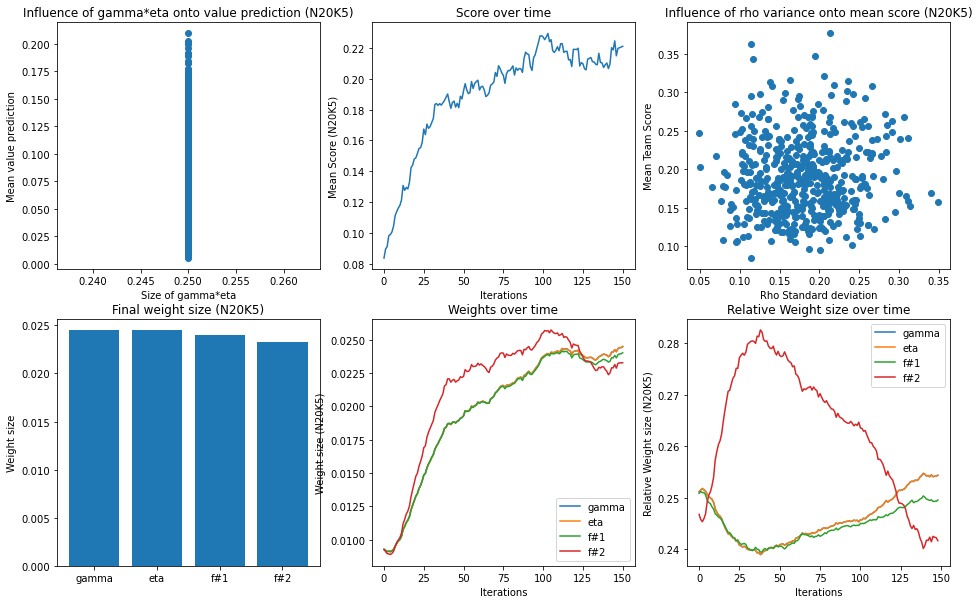

In [322]:
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

labels = ["gamma", "eta"]
labels.extend([f"f#{_+1}" for _ in range(n_features - 2)])
# mean_leadership = (
#     all_leadership_scores.reshape((n_trials, n_agents, n_agents)).mean(axis=2).flatten()
# )
for i, l in enumerate(labels):
    print(
        f"Correlation leadership score and {l}", pearsonr(results[:, n_features * 2 +2], results[:, i])
    )

print("\n",
    ((all_leadership_scores == 0).sum() / 7 / (n_trials * n_agents) * 100).round(2),
    "% of agents are never voted as leaders \n",
)

# Correlation_plots
x = results[:, 0] * results[:, 1]
y = results[:, n_features * 2]
axs[0, 0].scatter(x, y)
# m, c = np.polyfit(x, y, 1)
axs[0, 0].set_title(f"Influence of gamma*eta onto value prediction (N{N}K{K})")
# axs[0, 0].plot(x, m * x + c, "r")
axs[0, 0].set_xlabel("Size of gamma*eta")
axs[0, 0].set_ylabel("Mean value prediction")

# Score over time
axs[0, 1].plot(all_scores)
axs[0, 1].set_xlabel("Iterations")
axs[0, 1].set_ylabel(f"Mean Score (N{N}K{K})")
axs[0, 1].set_title("Score over time")


x = results[:, 3].reshape((n_trials, n_agents)).std(axis=1)  # std of rho in a team
y = results[:, n_features * 2 + 1].reshape((n_trials, n_agents)).mean(axis=1)
axs[0, 2].scatter(x, y)
# m, c = np.polyfit(x, y, 1)
axs[0, 2].set_title(f"Influence of rho variance onto mean score (N{N}K{K})")
# axs[0, 2].plot(x, m * x + c, "r")
axs[0, 2].set_xlabel("Rho Standard deviation")
axs[0, 2].set_ylabel("Mean Team Score")
print("Relation of rho std and the mean score of a team", pearsonr(x, y))


# Weight size
axs[1, 0].bar(x=labels, height=results[:, n_features : n_features * 2].mean(axis=0))
axs[1, 0].set_title(f"Final weight size (N{N}K{K})")
axs[1, 0].set_ylabel("Weight size")

# Weights over time
[axs[1, 1].plot(all_weights[:, i], label=labels[i]) for i in range(len(labels))]
axs[1, 1].legend()
axs[1, 1].set_xlabel("Iterations")
axs[1, 1].set_ylabel(f"Weight size (N{N}K{K})")
axs[1, 1].set_title("Weights over time")

rel_weights = all_weights / all_weights.sum(axis=1).reshape(-1,1)
[axs[1, 2].plot(rel_weights[2:, i], label=labels[i]) for i in range(len(labels))]
axs[1, 2].legend()
axs[1, 2].set_xlabel("Iterations")
axs[1, 2].set_ylabel(f"Relative Weight size (N{N}K{K})")
axs[1, 2].set_title("Relative Weight size over time")


Features with a higher variance have a lower weight naturally learned by the regression.
- Why?

Features with a lower mean have a lower weight
- Why?

##### Label ideas:
Every algorithm needs some form of prediction error. How to measure the value of an agent?

- The score itself
    - All weights are highly positive as all features are needed to get the performance measure
    - Use bias neuron (f#0 = 1)
- The difference to the previous score
    - extremly small value
    - Scaling it higher?
- Scaling to possible value
    - Normalize so that the worst score of an agent would be 0 and best 1
    - Reward is higher
    - can be basis for every agent comparing its own solution with the agent
- Every agent compares the voted answer with its own best possible answer
    - Good agents don't vote others
    - Bad ones don't vote for themselves
    - leader_value - values --> leads to positive values if good choice (clip at 0 to say, bad agents just don't have a reward (no negative weights)
   
   
$\hat{R}_{S=i} = \left\{
\begin{aligned}
R_{S=i} - R_{all} \quad  \hat{R}_{S=i} \geq 0\\
0 \quad  \hat{R}_{S=i} \leq 0 \\
\end{aligned}
\right.$

### Voting mechanisms 
&rarr; Collective Decision Making with implications for leadership

In this case a leader needs to propose a solution to have an efficient system.
Team should not discuss it, but has a distinct communication phase
Voting seems to be a reasonable and realistic choice. Alternatively some for agreement scales 

Followers grant leaders influence onto their social behaviour.

Attributes usually mentioned with decision making
- Credebility
- Confidence

Voting for:
- Proposals
- Leaders


Information to base the decision on:
- Mainly: Social influence or Proposal Value
- Leaders: Social influence
- Leaders: Proposal Value compared to current value
- Proposals: Based on social influence of all proposers
- Proposals: Based on their value 

Does this correspond to the type of leadership?

Voting mechanisms
- Majority vote
- Special vote (see paper of reading group)

- (votes over time if information spreads) 

### Introducing Privilege

1. **Model Minorities**
* Distribution of rho based on two distributions
* Minorities with high rho or low?
* Restrictions:
    * Every team should inclue at least one minority agent but not more then 50% of the team
    * Mean of rho should be 0.5
* If there are always 2 out of 7 agents minority agents then: 
    * 0.75 * (2/7) + x *(5/7) = 0.5
        * --> x = 2/5 




2. **Policy & Initialisation changes**

**Static social structures**:
* Introduce a leadership/social_influence matrix which impacts informatin sharing or voting
* Initialize with a given structure based on features and privilege
* Incorporate snowball behaviour into policy -> Once someone has a fixed good position, it usually doe not lose the position anymore, based on the advantages it brings 
    * Real world: Restrict other or make use of ressources other don't have
    * Simulation: More information or rules restricting info sharing (costly)
    
**Unfair communication policy**
* Sharing information can make individuals vulnerable, that's why need to trust someone beforehand
* Only grant access to information to other agents if they are like-minded --> have similar feature values
* Possible good leaders and ideas from minorities will get ignored and even their information discarded
    
### Intervention
* Mentors can boost the ressources and also reputation of an individual 
* Simulation: While communicating ideas and agents of minorities are now valued as they are associated with their Mentors
    * Agents see and value the decision of an agent, because they value the mentor
    * Should lead to unlearning the bias and have steady behaviour after mentors leave again

## Old code

## Leadership Features (Collective Search)

### Feature Ideas
* **Information distribution for agents**
Agents have a personality feature which corresponds to the bits they can change $\rho \in [0,1]$ sampled from $\mathbf{U}(0,1)$. The bit is sampled from $\mathbf{N}(\rho, 0.2)$, rounded and multiplied by 10. This means with $\rho = 0.2$ a gaussian with mean 0.2 is sampled and the result (likely 0.2) is used to define the bit (which would be 2)


* **Communication ability**
Agents have a feature $\gamma$ which is the probability of receiving information about the proposed change of another agent. This means agents with high $\gamma$ have more knowledge of possible improvements.


* **Performance Judgement**
Additional every agent has an attribute $\eta$ which models the competency of leading. After agents collect their information they assess which change they would propose if they are to decide the change. Some exploit their knowledge and choose the best, whereas others may have the information but do not know how to use it.


* **Creativity**
Agents take its received solutions and recombines them to search for even better solutions (instead of one bit switch there are two)



**Leadership attributes**
- Simulation Paper: Talkativness; Communication quality/ quantity
- Emergence Paper: Motivation; Behaviour; Other attributions
- Skill
- Credebility
- Self-esteem
- Intelligence
- Motivation/ Motives


**Results of Leadership**
- Well being of followers
- Performance of team
- Shared vision
- Granting of influence

#### Communication probability (gamma)

0
100
200
300
400


Text(0.5, 1.0, 'Perfomance - Decider receives options with with P=gamma (N20K5)')

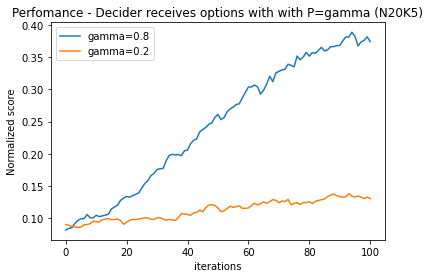

In [184]:
def run_gamma(env, gamma_i, iterations, rng):
    """Test if Communication feature makes a difference in performance"""
    # Initialize solution
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_fitness(state)
    state, score


    all_scores = np.empty(iterations+1)
    all_scores[0] = score
    
    agents_index = np.arange(n_agents)
    

    for i in range(iterations):
        # Changes of agents
        digits = rng.integers(0, N, n_agents)

        # Evaluation
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_fitness(search_state) for search_state in search_states])
        
        # Communication
        communication_index = rng.random(n_agents) <= gamma_i
        scores = scores[communication_index]
        search_states = search_states[communication_index]
        
        if len(scores) == 0:
            all_scores[i+1] = score
            continue
        
        # Same agent draws from its solutions
        p_proposals = softmax(scores, ((i+1)/iterations)*30 )
        change_digit = rng.choice(np.arange(len(scores)), p=p_proposals)

        # if scores[change_digit] >= score:
        state = search_states[change_digit]
        score = scores[change_digit]

        all_scores[i+1] = score
    
    return all_scores

rng = np.random.default_rng(0)
iterations = 100
n_trials = 500

n_agents = 7

# Communication feature of one agent
gamma_high = 0.8
gamma_low = 0.2
score_gamma_high = np.empty((n_trials, iterations+1))
score_gamma_low = np.empty((n_trials, iterations+1))


for i in range(n_trials):
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0 ,n_landscapes)])
    
    score_gamma_high[i] = run_gamma(env, gamma_high, iterations, rng)
    score_gamma_low[i] = run_gamma(env, gamma_low, iterations, rng)
    if i%100 == 0:
        print(i)


plt.plot(score_gamma_high.mean(axis=0), label="gamma=0.8")
plt.plot(score_gamma_low.mean(axis=0), label="gamma=0.2")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("Normalized score")
plt.title(f"Perfomance - Decider receives options with with P=gamma (N{N}K{K})")

#### Information exploitation (eta) 

Start
0
50
100
150
200
250
300
350
400
450
End


Text(0.5, 1.0, 'Team Perfomance - Inv. Temp of decider (gamma=0.8) (N20K5)')

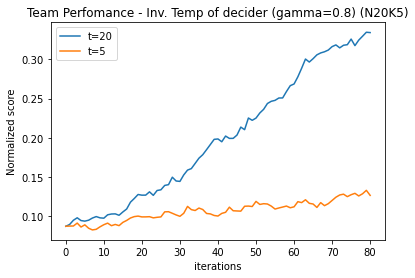

In [186]:
def run_gamma_eta(env, gamma_i, eta_i, iterations, rng):
    """Test if Communication feature makes a difference in performance"""
    # Initialize solution
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_fitness(state)
    state, score


    all_scores = np.empty(iterations+1)
    all_scores[0] = score
    
    agents_index = np.arange(n_agents)
    

    for i in range(iterations):
        # Changes of agents
        digits = rng.integers(0, N, n_agents)

        # Evaluation
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_fitness(search_state) for search_state in search_states])
        
        # Communication
        communication_index = rng.random(n_agents) <= gamma_i
        scores = scores[communication_index]
        search_states = search_states[communication_index]
        
        if len(scores) == 0:
            all_scores[i+1] = score
            continue
        
        # Same agent draws from its solutions
        p_proposals = softmax(scores, ((i+1)/iterations) * eta_i) # ((i+1)/iterations)*30 )
        change_digit = rng.choice(np.arange(len(scores)), p=p_proposals)

        # if scores[change_digit] >= score:
        state = search_states[change_digit]
        score = scores[change_digit]

        all_scores[i+1] = score
    
    return all_scores

rng = np.random.default_rng(1)
iterations = 80
n_trials = 500

n_agents = 7


# Communication feature of one agent
gamma = 0.8
t_low = 5
t_high = 20
score_t_high = np.empty((n_trials, iterations+1))
score_t_low = np.empty((n_trials, iterations+1))

print("Start")
for i in range(n_trials):
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0, n_landscapes)])

    score_t_high[i] = run_gamma_eta(env, gamma, t_high, iterations, rng)
    score_t_low[i] = run_gamma_eta(env, gamma, t_low, iterations, rng)
    if i%50 == 0:
        print(i)
print("End")

plt.plot(score_t_high.mean(axis=0), label="t=20")
plt.plot(score_t_low.mean(axis=0), label="t=5")
plt.legend()
plt.xlabel("iterations")
plt.ylabel("Normalized score")
plt.title(f"Team Perfomance - Inv. Temp of decider (gamma=0.8) (N{N}K{K})")

### Result of feature selection

* Random exploration (with P=0.2) worsens the performance (results in file: NK landscapes)


* Communication probability gamma: positive correlated to performance


* Exploitation of options t: Also positive correlated to performance (with th assumption of a big choice)


* &rarr; Communication probability & Exploitation together weaken, but work together

### Learning of social influence

##### Algorithms
* ICA: Independent Component Analysis
    * Does not apply here. It can figure out source signals if a signal consists of different independent sources. in our case the performance does not directly consist of the features. The features only correlate to the performance.
   
   
* RW Learning + Softmax: Voting for an Agent is like choosing an action
    * Simplest approach
    * No feature weights


* Feature based RL: Proposed by Charley https://www.jneurosci.org/content/35/21/8145.full#F1
    * Paper: The value of an object consists of its features (shape: circle or rectangle, colour: blue, red, ...)
    * Updates weights for each feature based on observations
    * Problem: Features here are $\in U(0,1)$ and not {x, y, z}
        * Potential solution: Create bins low-mid-high and learn weights for them
    * Paper: Task 9 feature (3x3) -> 3 options of combinations given. If chosen correctly reward = 1 else 0
        * Also has a Baysian approach


* Value Function approximation (VFA):
    * CCN Solution
    * Label (see section):
        * Performance
            * Only one agent
            * Difference in Performance (Agents have access to everyones performance)
    * May fits theory nicely: Real world humans often learn value functions as well 


* Baysian Approaches:
    * Possibility of biased prior
    * Bayesian Inference
    * Baysian Linear Regression
        * not a Baysian method but maybe useful
    * Baysian RL


* Actor Critic RL Method


* Inverse RL (IRL)
    * Infer reward function and policy of other agents by observing their state and actions


* naive utility calculus
    * Theory of mind approach: https://www.sciencedirect.com/science/article/pii/S0010028520300633
    * Goeas further then Inverse RL: Explains human reasoning (approximation) instead of best optimal policy

---


* Other ideas:
    * Decaying social influence over time (if not chosen)
    * Cost of communication (everyone needs to talk to everyone in the beginning)
    * 

**Value function differences (IRL vs. VFA)**
* Value function approximation tries to approximate the value of states so an agent learns its environment 
    * iteratively updating weights for state features.
    * state are the attributes of the chosen agent
    * reward is the payoff the agent provides
* For naive calculus the objective is to approximate someone elses value function to understand what another agent is doing.
    * This means given states and actions of other agents, the objective is to infer what the other agents values/ belief in
    

#### RL with RW-Learning

In [ ]:
def run_RWL_voting(env, gammas, iterations, rng):
    """Test if Communication feature makes a difference in performance"""
    # Initialize solution
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_fitness(state)
    state, score

    all_scores = np.empty(iterations+1)
    all_scores[0] = score
    
    agents_index = np.arange(n_agents)
    
    gammas = f[:,0]
    etas = f[:,1] * 15
    lr = 0.1
    social_influence = np.zeros((n_agents, n_agents))

    for i in range(iterations):
        # Changes of agents
        digits = rng.integers(0, N, n_agents)

        # Evaluation
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_fitness(search_state) for search_state in search_states])
        
        # Communication
        all_agent_scores = dict()
        all_agent_states = dict()
        for agent_i in range(n_agents):
            communication_index = rng.random(n_agents) <= gammas[agent_i]
            all_agent_scores[agent_i] = scores[communication_index]
            all_agent_states[agent_i] = search_states[communication_index]
        
        # Vote # TODO sofmax along axis
        p_votings = softmax(social_influence, 5, axis=1) # TODO: Which exploitation to use?
        votes = []
        for p in p_votings:
            votes.append(rng.choice(np.arange(n_agents), p=p))
        
        vote_agent_index, vote_count = np.unique(np.array(votes), return_counts=True)
        speaker = list(vote_count).index(max(vote_count))        # TODO: Always returns first index (if tie always the same gets chosen)
        
        # Applying solution
        if len(all_agent_scores[speaker]) == 0:
            all_agent_scores[speaker] = np.array([scores[speaker]])
            all_agent_states[speaker] = np.array([search_states[speaker]])

        
        # Speaker draws from its known solutions
        scores = all_agent_scores[speaker]
        p_proposals = softmax(scores, ((i+1)/iterations) * etas[speaker])
        change_digit = rng.choice(np.arange(len(scores)), p=p_proposals)

        # Update social influence
        
        social_influence[:,speaker] = social_influence[:,speaker] + lr * (scores[change_digit] - score)
        
        state = all_agent_states[speaker][change_digit]
        score = scores[change_digit]
        
        all_scores[i+1] = score
    
    return social_influence.mean(axis=0)

rng = np.random.default_rng(1)
iterations = 80
n_trials = 500
n_agents = 7

# Communication feature of one agent
results = np.empty((n_trials*n_agents, 3))


print("Start")
for i in range(n_trials):
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0, n_landscapes)])
    
    f = rng.random((n_agents, 2))
    social_influence = run_RWL_voting(env, gammas, iterations, rng)
    
    results[i*n_agents : i*n_agents + n_agents][:,0] = f[:,0]
    results[i*n_agents : i*n_agents + n_agents][:,1] = f[:,1]
    results[i*n_agents : i*n_agents + n_agents][:,2] = social_influence 
    
    if i%100 == 0:
        print(i)
print("End")

fig, ax = plt.subplots(1,2, figsize=(12,6))
y = results[:,2]

x = results[:,0]
ax[0].scatter(x, y)
m, c = np.polyfit(x,  y, 1)
ax[0].set_title(f"Influence of gamma onto ones social influence (N{N}K{K})")
ax[0].plot(x, m*x + c, 'r')
ax[0].set_xlabel("Size of Gamma")
ax[0].set_ylabel("Mean Social influence")
print(pearsonr(x, y))

x = results[:,1]
ax[1].scatter(x, y)
m, c = np.polyfit(x,  y, 1)
ax[1].set_title(f"Influence of eta onto ones social influence (N{N}K{K})")
ax[1].plot(x, m*x + c, 'r')
ax[1].set_xlabel("Size of Eta")
ax[1].set_ylabel("Mean Social influence")
print(pearsonr(x, y))

### Individual Search (Collective Hill Climbing)
Local Search based on shared solution

Possible algorithms:
- Hill Climbing
    - Greedy
    - Stochastic
    - First choice
    - Random restart
- Simulated Annealing
- Local beam search
    - stochastic beam search
- Genetic algorithms


0
50
100
150
200
250


Text(0.5, 1.0, 'Considering Multiple changes (N20K5)')

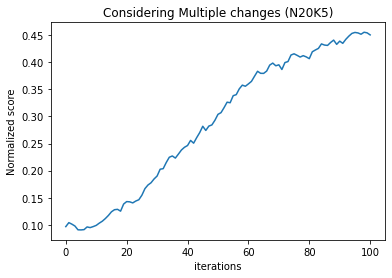

In [183]:
def SHC(env, iterations, n_agents, rng):
    """Consider Multiple changes and softmax with annealing for choice"""
    state = np.round(rng.random(env.N)).astype(int)
    score = env.get_fitness(state)
    state, score


    all_scores = np.empty(iterations+1)
    all_scores[0] = score

    for i in range(iterations):
        # every agents changes a random bit
        digits = rng.integers(0, N, n_agents)

        # Evaluate changes
        search_states = np.array([bit_switch(digit, state.copy()) for digit in digits])
        scores = np.array([env.get_fitness(search_state) for search_state in search_states])
        # Softmax decides which to implement
        p_proposals = softmax(scores, ((i+1)/iterations)*30 )
        # print(p_proposals)
        change_digit = rng.choice(np.arange(n_agents), p=p_proposals)

        # if scores[change_digit] >= score:
        state = search_states[change_digit]
        score = scores[change_digit]

        all_scores[i+1] = score
    
    return all_scores

rng = np.random.default_rng(0)

iterations = 100
n_trials = 300
n_agents = 7

score_tracker = np.empty((n_trials, iterations+1))

for i in range(n_trials):
    env = NK_landscape_loaded(N, K, landscapes[rng.integers(0, n_landscapes)])        
    score_tracker[i] = SHC(env, iterations, n_agents, rng)
    if i%50 == 0:
        print(i)

plt.plot(score_tracker.mean(axis=0))
plt.xlabel("iterations")
plt.ylabel("Normalized score")
plt.title(f"Considering Multiple changes (N{N}K{K})")

##### Collective Hill Climbing RESULT
* Stochastic Hill Climbing provide good results with an inverse decaying temperature
    * linear temperature decay
    
* Other algorithms like genetic algorithms or Beam Search may be overly complex and do not suit the independent search of single agents